In [3]:
import pandas as pd
df = pd.read_csv("data/df_clean_with_clusters.csv")
print(df.shape)


(1003, 31)


In [4]:
#Build scaled feature matrix + nearest-neighbor index

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

feature_cols = ["r_mean","g_mean","b_mean","r_std","g_std","b_std","contrast","edge_density","sharpness",
                "sat_mean","colorfulness","gray_score"]

df = df.dropna(subset=feature_cols).copy()

scaler = StandardScaler()
X = scaler.fit_transform(df[feature_cols].values)

# nearest neighbors model
nn = NearestNeighbors(n_neighbors=25, metric="cosine")
nn.fit(X)

print("NN index built:", X.shape)


NN index built: (1003, 12)


In [5]:
#Define a “marketability score”

# cluster size rarity proxy
cluster_counts = df["cluster"].value_counts()
df["cluster_size"] = df["cluster"].map(cluster_counts)

# novelty proxy: distance to cluster centroid (in scaled space)
centroids = {}
for c in sorted(df["cluster"].unique()):
    centroids[c] = X[df["cluster"].values == c].mean(axis=0)

def novelty(i):
    c = int(df.iloc[i]["cluster"])
    return float(np.linalg.norm(X[i] - centroids[c]))

nov = np.array([novelty(i) for i in range(len(df))])
df["novelty"] = (nov - nov.min()) / (nov.max() - nov.min() + 1e-9)

# normalize some features for scoring
def norm(col):
    v = df[col].values
    return (v - v.min()) / (v.max() - v.min() + 1e-9)

df["impact"] = 0.45*norm("colorfulness") + 0.25*norm("contrast") + 0.15*norm("edge_density") + 0.15*norm("sat_mean")
df["rarity"] = 1 - norm("cluster_size")  # smaller cluster = rarer

# final score (tweakable)
df["marketability_score"] = 0.60*df["impact"] + 0.25*df["novelty"] + 0.15*(1 - df["rarity"])  
# (1-rarity) means we slightly prefer more broadly appealing clusters; flip if you want "niche cool"

df.sort_values("marketability_score", ascending=False)[["title","artist","cluster","marketability_score"]].head(10)


title  \
69      Volpini Suite: Laundresses (Les Laveuses)   
689                                        Isolde   
322                               Salute first...   
722                                    May Milton   
391          Loom width with Stylized Leaf Design   
0                           Shazanrō Picture Book   
904                             Saint Christopher   
500                           Tiger in the Jungle   
937           Couple in Room, Nude Man with Woman   
803  Woman with Red Hair and Green Eyes (The Sin)   

                                            artist  cluster  \
69                Paul Gauguin (French, 1848–1903)        3   
689          Aubrey Beardsley (British, 1872–1898)        3   
322      Félix Vallotton (Swiss French, 1865–1925)        3   
722  Henri de Toulouse-Lautrec (French, 1864–1901)        3   
391                                            NaN        9   
0                Tani Bunchō (Japanese, 1763–1841)        3   
904              Lucas Cranach (German, 1472–1553)        9   
500           Paul Elie Ranson (French, 1862–1909)       17   
937      Ernst Ludwig Kirchner (German, 1880–1938)       17   
803            Edvard Munch (Norwegian, 1863–1944)        3   

     marketability_score  
69              0.643049  
689             0.624498  
322             0.560605  
722             0.492642  
391             0.475120  
0               0.467678  
904             0.464297  
500             0.459490  
937             0.452176  
803             0.447050

In [6]:
#Recommendation function

def recommend_by_index(idx, k=12):
    distances, indices = nn.kneighbors(X[idx:idx+1], n_neighbors=k+1)
    recs = indices[0][1:]  # skip itself
    out = df.iloc[recs][["file","title","artist","cluster","marketability_score"]].copy()
    return out

# Example: pick one random item and get recs
idx = 0
recommend_by_index(idx, k=12).head()


file  \
275  45f6764e11bac6a28d3fd534d468dc62.jpg   
566  940a69e3d4fd5b4ccf10eea9ea2c9fae.jpg   
974  fa135fa87b0f1ea697c83d2dec39474c.jpg   
489  7b4be6bb603d5b55c3ebf33659b62ae3.jpg   
329  52895c41106d3ea4473181d8f94adcd3.jpg   

                                                 title  \
275  Onoe Kikugorō I as Izumi no Saburō in the Play...   
566                      Child Reaching for a Fishbowl   
974                      The Parinirvana of the Buddha   
489  Hinazura of Chōjiya from the series Beauties a...   
329    Chushingura: Act X of The Storehouse of Loyalty   

                                              artist  cluster  \
275  Ippitsusai Bunchō (Japanese, active c. 1765–92)        3   
566       Nishimura Shigenaga (Japanese, 1697?-1756)       10   
974                                              NaN       10   
489           Utagawa Toyokuni (Japanese, 1769–1825)        0   
329        Kitagawa Utamaro (Japanese, c. 1754–1806)       16   

     marketability_score  
275             0.357504  
566             0.327695  
974             0.385671  
489             0.327646  
329             0.333164

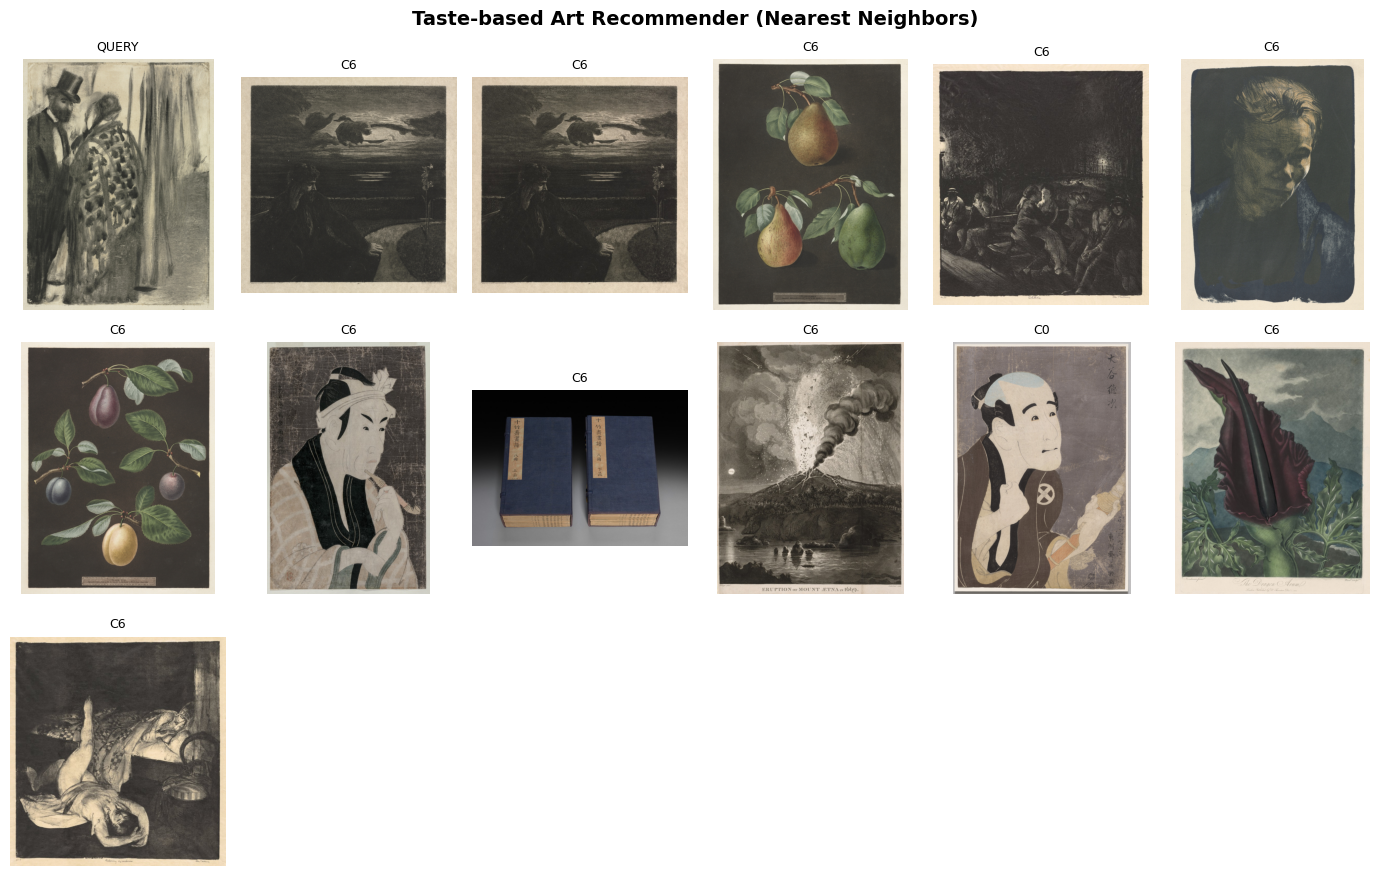

In [7]:
#Show the recommended images

import os, numpy as np
from PIL import Image
import matplotlib.pyplot as plt

IMG_DIR = "data/images_cma"

def show_recommendations(idx, k=12):
    recs = recommend_by_index(idx, k=k)
    base_file = df.iloc[idx]["file"]

    files = [base_file] + recs["file"].tolist()
    titles = ["QUERY"] + [f"C{c}" for c in recs["cluster"].tolist()]

    cols = 6
    rows = int(np.ceil(len(files)/cols))
    plt.figure(figsize=(14, 3*rows))

    for i, (fn, lab) in enumerate(zip(files, titles), start=1):
        p = os.path.join(IMG_DIR, fn)
        try:
            im = Image.open(p).convert("RGB")
        except Exception:
            continue
        plt.subplot(rows, cols, i)
        plt.imshow(im)
        plt.title(lab, fontsize=9)
        plt.axis("off")

    plt.suptitle("Taste-based Art Recommender (Nearest Neighbors)", y=0.98, fontsize=14, weight="bold")
    plt.tight_layout()
    plt.show()

show_recommendations(idx=25, k=12)


In [8]:
import os
import numpy as np
import pandas as pd
from PIL import Image

from skimage.color import rgb2gray, rgb2hsv
from skimage.feature import hog
from skimage.transform import resize

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

IMG_DIR = "data/images_cma"
df = pd.read_csv("data/df_clean_with_clusters.csv").dropna(subset=["file"]).copy()
print(df.shape)


C:\Users\meera\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


(1003, 31)


In [9]:
#Embedding function (structure + color)

def embed_hog_hsv(path):
    im = Image.open(path).convert("RGB")
    arr = np.asarray(im, dtype=np.float32) / 255.0

    # resize to stable size
    arr = resize(arr, (256, 256), anti_aliasing=True)

    # HOG for structure (captures linework/composition)
    gray = rgb2gray(arr)
    hog_feat = hog(
        gray,
        orientations=9,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        feature_vector=True,
    )

    # HSV hist for color palette
    hsv = rgb2hsv(arr)
    h = hsv[:, :, 0].ravel()
    s = hsv[:, :, 1].ravel()
    v = hsv[:, :, 2].ravel()

    hist_h, _ = np.histogram(h, bins=24, range=(0, 1), density=True)
    hist_s, _ = np.histogram(s, bins=12, range=(0, 1), density=True)
    hist_v, _ = np.histogram(v, bins=12, range=(0, 1), density=True)

    feat = np.concatenate([hog_feat, hist_h, hist_s, hist_v]).astype(np.float32)

    # normalize (cosine works better)
    feat /= (np.linalg.norm(feat) + 1e-9)
    return feat


In [10]:
#Build embeddings

import pickle

CACHE_PATH = "data/embeddings_hog_hsv.pkl"

if os.path.exists(CACHE_PATH):
    with open(CACHE_PATH, "rb") as f:
        obj = pickle.load(f)
    dfE = obj["dfE"]
    E = obj["E"]
    print("Loaded cached embeddings:", E.shape)
else:
    embeddings = []
    kept_rows = []

    for i, row in enumerate(df.itertuples(index=False), 1):
        fn = row.file
        p = os.path.join(IMG_DIR, fn)
        try:
            emb = embed_hog_hsv(p)
            embeddings.append(emb)
            kept_rows.append(row)
        except Exception:
            continue

        if i % 200 == 0:
            print("Embedded", i)

    E = np.vstack(embeddings)
    dfE = pd.DataFrame(kept_rows, columns=df.columns)

    with open(CACHE_PATH, "wb") as f:
        pickle.dump({"dfE": dfE, "E": E}, f)

    print("Saved cache:", CACHE_PATH, "shape:", E.shape)


Loaded cached embeddings: (1003, 8148)


In [11]:
#Nearest neighbor index

scaler = StandardScaler(with_mean=False)
E2 = scaler.fit_transform(E)

nn = NearestNeighbors(n_neighbors=25, metric="cosine")
nn.fit(E2)

def recommend_by_file(query_file, k=12):
    qi = dfE.index[dfE["file"] == query_file][0]
    d, idx = nn.kneighbors(E2[qi:qi+1], n_neighbors=k+1)
    rec_idx = idx[0][1:]
    return dfE.iloc[rec_idx][["file", "title", "artist", "cluster"]]


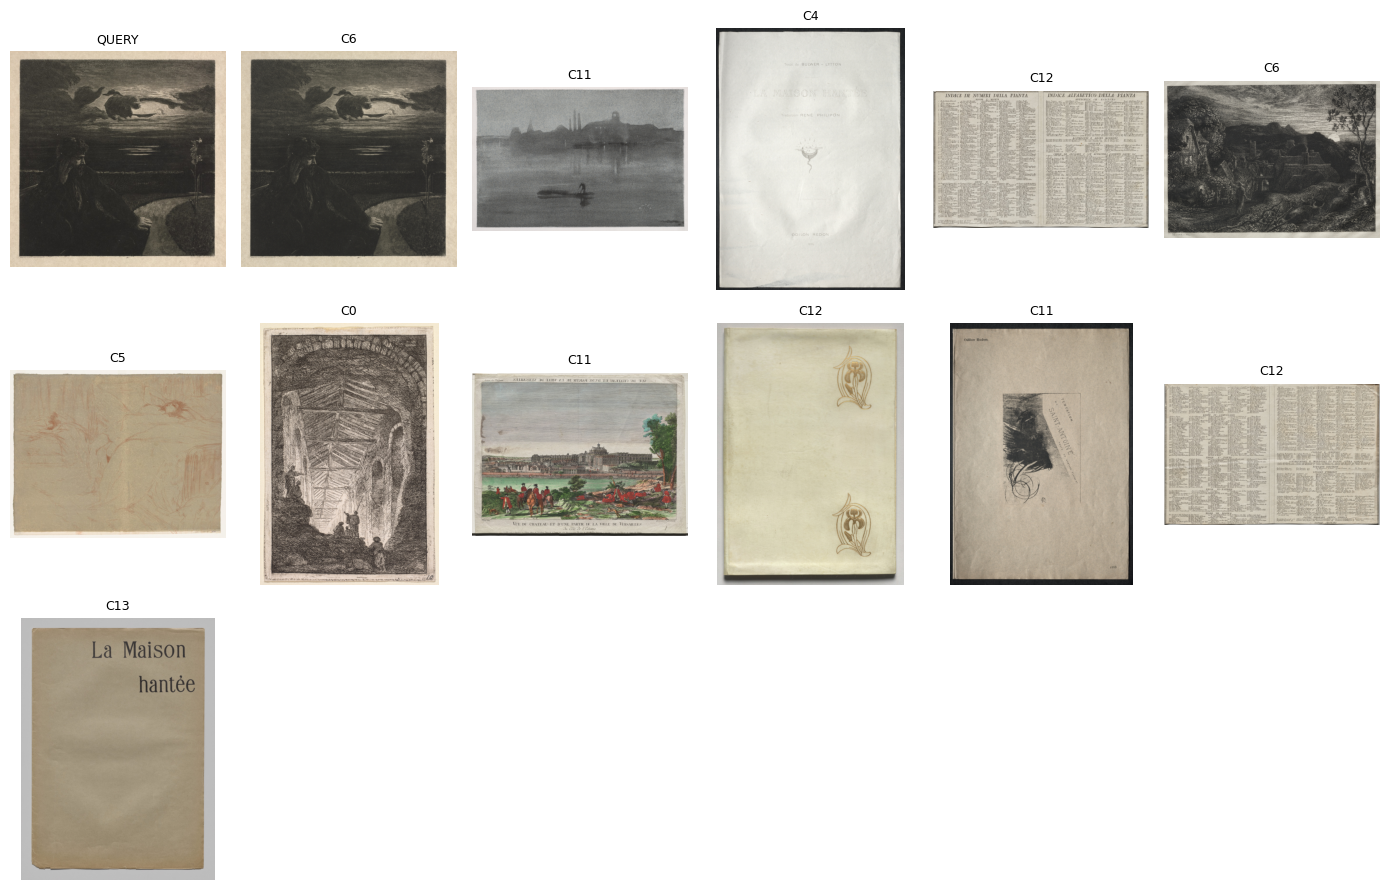

In [12]:
#Show recommendations grid

import matplotlib.pyplot as plt

def show_recs(query_file, k=12):
    recs = recommend_by_file(query_file, k=k)
    files = [query_file] + recs["file"].tolist()
    labels = ["QUERY"] + [f"C{c}" for c in recs["cluster"].tolist()]

    cols = 6
    rows = int(np.ceil(len(files)/cols))
    plt.figure(figsize=(14, 3*rows))

    for i, (fn, lab) in enumerate(zip(files, labels), start=1):
        p = os.path.join(IMG_DIR, fn)
        try:
            im = Image.open(p).convert("RGB")
        except Exception:
            continue
        plt.subplot(rows, cols, i)
        plt.imshow(im)
        plt.title(lab, fontsize=9)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Try a random query
qf = dfE.sample(1, random_state=42)["file"].iloc[0]
show_recs(qf, k=12)


In [13]:
#Lightweight evaluation: “Style-consistency@k” 
#We’ll measure: for a query image, what % of the top-k recommendations share the same cluster as the query

import numpy as np

def style_consistency_at_k(k=12, n_queries=200, seed=42):
    rng = np.random.default_rng(seed)
    idxs = rng.choice(len(dfE), size=min(n_queries, len(dfE)), replace=False)

    same = []
    for qi in idxs:
        q_cluster = int(dfE.iloc[qi]["cluster"])
        d, idx = nn.kneighbors(E2[qi:qi+1], n_neighbors=k+1)
        rec_idx = idx[0][1:]
        rec_clusters = dfE.iloc[rec_idx]["cluster"].astype(int).values
        same.append((rec_clusters == q_cluster).mean())

    return float(np.mean(same)), float(np.median(same))

mean_sc, med_sc = style_consistency_at_k(k=12, n_queries=200)
print("Style-consistency@12  mean:", round(mean_sc,3), " median:", round(med_sc,3))


Style-consistency@12  mean: 0.165  median: 0.083


In [14]:
import os
import matplotlib.pyplot as plt
from PIL import Image

os.makedirs("outputs/recommender_examples", exist_ok=True)

def save_recs_grid(query_file, out_path, k=12):
    recs = recommend_by_file(query_file, k=k)
    files = [query_file] + recs["file"].tolist()
    labels = ["QUERY"] + [f"C{c}" for c in recs["cluster"].tolist()]

    cols = 6
    rows = int(np.ceil(len(files)/cols))
    plt.figure(figsize=(14, 3*rows))

    for i, (fn, lab) in enumerate(zip(files, labels), start=1):
        p = os.path.join(IMG_DIR, fn)
        try:
            im = Image.open(p).convert("RGB")
        except Exception:
            continue
        plt.subplot(rows, cols, i)
        plt.imshow(im)
        plt.title(lab, fontsize=9)
        plt.axis("off")

    plt.tight_layout()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()

# Save 10 examples
sample_files = dfE.sample(10, random_state=7)["file"].tolist()
for i, qf in enumerate(sample_files, 1):
    save_recs_grid(qf, f"outputs/recommender_examples/example_{i:02d}.png", k=12)

print("Saved 10 grids in outputs/recommender_examples/")


Saved 10 grids in outputs/recommender_examples/


In [15]:
def recommend_for_external_image(image_path, k=12):
    q_emb = embed_hog_hsv(image_path)
    q_emb = q_emb / (np.linalg.norm(q_emb) + 1e-9)
    q_vec = scaler.transform(q_emb.reshape(1, -1))

    d, idx = nn.kneighbors(q_vec, n_neighbors=k)
    rec_idx = idx[0]
    return dfE.iloc[rec_idx][["file","title","artist","cluster"]]

# Example:
# recs = recommend_for_external_image("my_upload.jpg", k=12)
# recs.head()


In [16]:
## Add “User Taste Profile” (personalized recommendations)

In [17]:
#Build a user taste vector from liked items

import numpy as np

def taste_vector_from_files(liked_files):
    liked_files = [f for f in liked_files if f in set(dfE["file"])]
    if len(liked_files) == 0:
        raise ValueError("None of the liked_files exist in dfE['file'].")

    idxs = [dfE.index[dfE["file"] == f][0] for f in liked_files]
    v = E2[idxs].mean(axis=0)  # average in scaled embedding space
    # L2 normalize (important for cosine)
    v = v / (np.linalg.norm(v) + 1e-9)
    return v


In [18]:
#Recommend based on taste vector (exclude already liked)

def recommend_from_taste(liked_files, k=18):
    v = taste_vector_from_files(liked_files)
    v2 = np.asarray(v).reshape(1, -1)   # <-- FIX: make it 2D

    d, idx = nn.kneighbors(v2, n_neighbors=k + len(liked_files))
    rec_files = []
    for i in idx[0]:
        f = dfE.iloc[i]["file"]
        if f not in liked_files:
            rec_files.append(i)
        if len(rec_files) >= k:
            break
    return dfE.iloc[rec_files][["file","title","artist","cluster"]]



In [19]:
liked = dfE.sample(3, random_state=1)["file"].tolist()  # replace with your own
recs = recommend_from_taste(liked, k=12)
recs.head()


file  \
276  4616db6e995bbf31291abc7baa7b0425.jpg   
64   1020bc0ece5573bb9b0145fd0e76a947.jpg   
133  23b7ac050a061195a0c7452e8c224562.jpg   
431  6e4c1d563237595cd0948a0d307354c2.jpg   
476  779c5190395c27a7b847789565aad0a3.jpg   

                                                 title  \
276                   The Shepherd and the Shepherdess   
64   Nuova pianta di Roma data in luce da Giambatti...   
133  Nuova pianta di Roma data in luce da Giambatti...   
431                                              Peony   
476                                 The Good Samaritan   

                                            artist  cluster  
276  Charles François Daubigny (French, 1817–1878)        6  
64    Giovanni Battista Nolli (Italian, 1701–1756)       12  
133   Giovanni Battista Nolli (Italian, 1701–1756)       12  
431             Kate Faulkner (British, 1841–1898)        8  
476           Rodolphe Bresdin (French, 1822–1885)        0

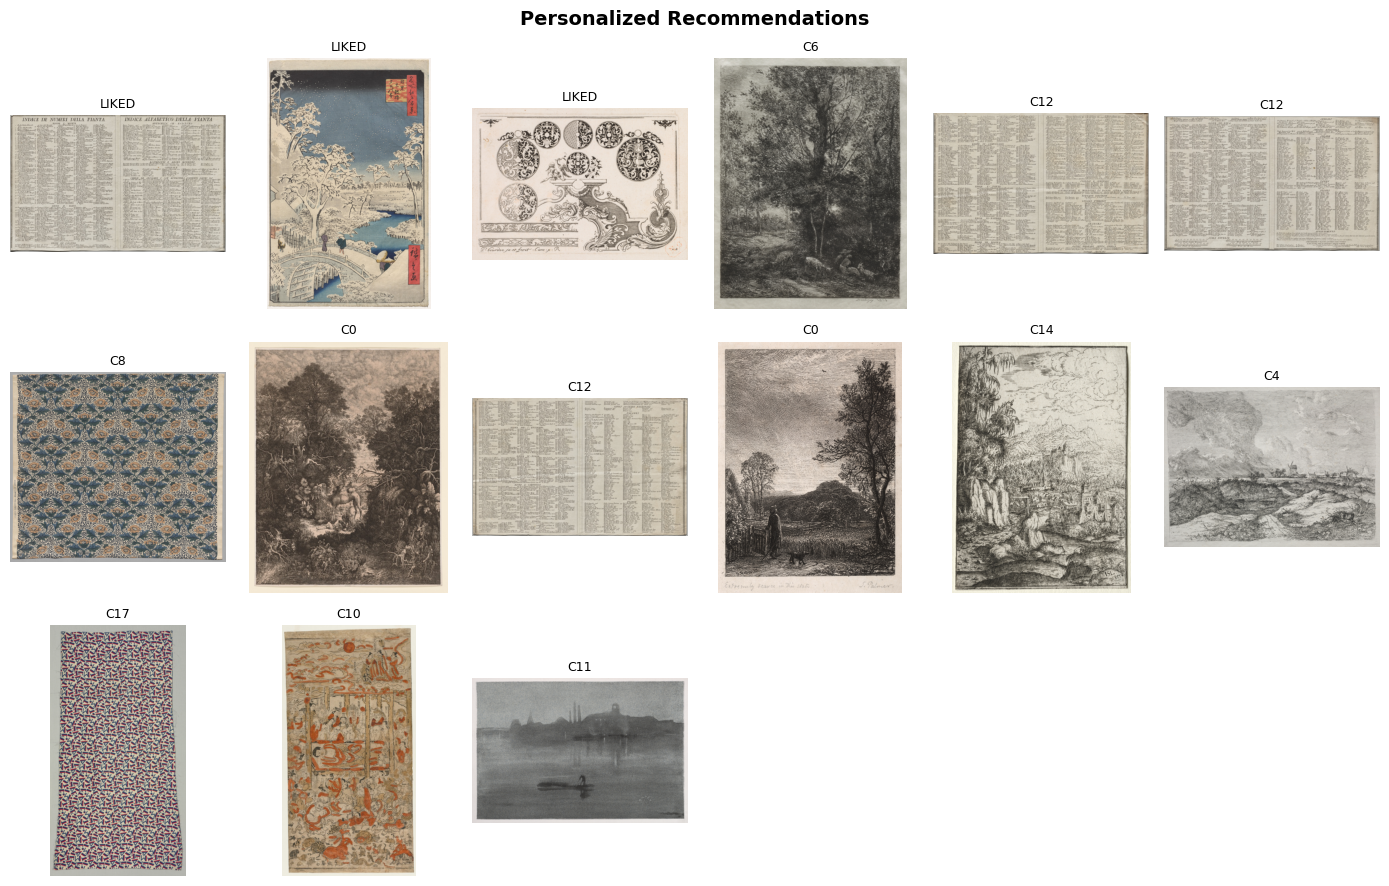

In [20]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def show_taste_recs(liked_files, k=12, title="Personalized Recommendations"):
    recs = recommend_from_taste(liked_files, k=k)
    files = liked_files + recs["file"].tolist()
    labels = ["LIKED"]*len(liked_files) + [f"C{c}" for c in recs["cluster"].tolist()]

    cols = 6
    rows = int(np.ceil(len(files)/cols))
    plt.figure(figsize=(14, 3*rows))

    for i, (fn, lab) in enumerate(zip(files, labels), start=1):
        p = os.path.join(IMG_DIR, fn)
        try:
            im = Image.open(p).convert("RGB")
        except Exception:
            continue
        plt.subplot(rows, cols, i)
        plt.imshow(im)
        plt.title(lab, fontsize=9)
        plt.axis("off")

    plt.suptitle(title, y=0.98, fontsize=14, weight="bold")
    plt.tight_layout()
    plt.show()

show_taste_recs(liked, k=12)


In [21]:
import pandas as pd
df_clean = pd.read_csv("data/df_clean_with_clusters.csv")  # change filename if needed
print(df_clean.columns)
df_clean[["x","y","cluster"]].head()


Index(['file', 'r_mean', 'g_mean', 'b_mean', 'r_std', 'g_std', 'b_std',
       'contrast', 'edge_density', 'sharpness', 'source', 'id', 'title',
       'artist', 'department', 'type', 'technique', 'medium', 'creation_date',
       'culture', 'image_url', 'canonical_url', 'x', 'y', 'cluster',
       'meta_text', 'is_photo_meta', 'sat_mean', 'colorfulness', 'gray_score',
       'likely_photo_visual'],
      dtype='object')


x          y  cluster
0 -15.891682  25.688833        3
1  26.775486  12.396326        7
2  18.905400   9.474260        2
3   9.664650 -19.141788       14
4 -23.005064   2.570751        5

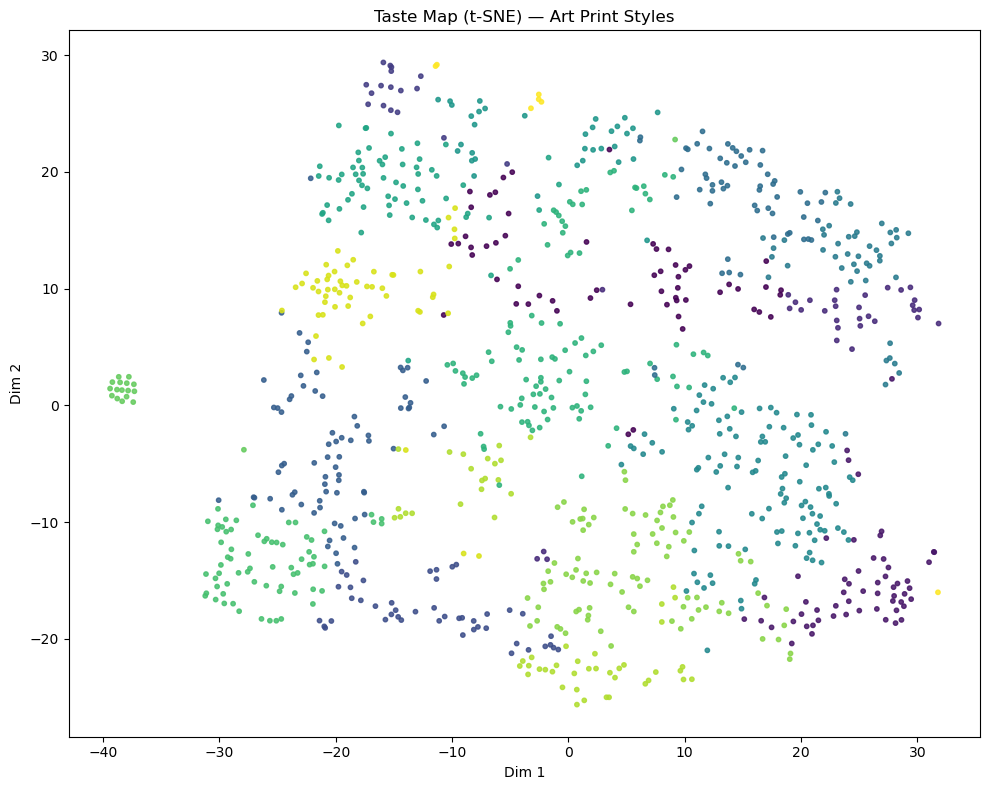

In [22]:
import matplotlib.pyplot as plt
import os
os.makedirs("outputs/linkedin", exist_ok=True)

plt.figure(figsize=(10,8))
plt.scatter(df_clean["x"], df_clean["y"], c=df_clean["cluster"], s=10, alpha=0.85)
plt.title("Taste Map (t-SNE) — Art Print Styles")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.tight_layout()
plt.savefig("outputs/linkedin/slide2_taste_map.png", dpi=220, bbox_inches="tight")
plt.show()


In [23]:
qf = dfE.sample(1, random_state=42)["file"].iloc[0]
save_recs_grid(qf, "outputs/linkedin/slide3_image_to_image.png", k=12)
print("Saved slide3")


Saved slide3


In [24]:
def save_taste_slide(liked_files, out_path, k=12):
    recs = recommend_from_taste(liked_files, k=k)
    files = liked_files + recs["file"].tolist()
    labels = ["LIKED"]*len(liked_files) + [f"C{c}" for c in recs["cluster"].tolist()]

    cols = 6
    rows = int(np.ceil(len(files)/cols))
    plt.figure(figsize=(14, 3*rows))

    for i, (fn, lab) in enumerate(zip(files, labels), start=1):
        p = os.path.join(IMG_DIR, fn)
        try:
            im = Image.open(p).convert("RGB")
        except Exception:
            continue
        plt.subplot(rows, cols, i)
        plt.imshow(im)
        plt.title(lab, fontsize=9)
        plt.axis("off")

    plt.suptitle("Personalized Taste Profile → Recommendations", y=0.98, fontsize=14, weight="bold")
    plt.tight_layout()
    plt.savefig(out_path, dpi=220, bbox_inches="tight")
    plt.close()

liked = dfE.sample(3, random_state=7)["file"].tolist()   # replace later with your chosen liked set
save_taste_slide(liked, "outputs/linkedin/slide4_personalization.png", k=12)
print("Saved slide4")


Saved slide4


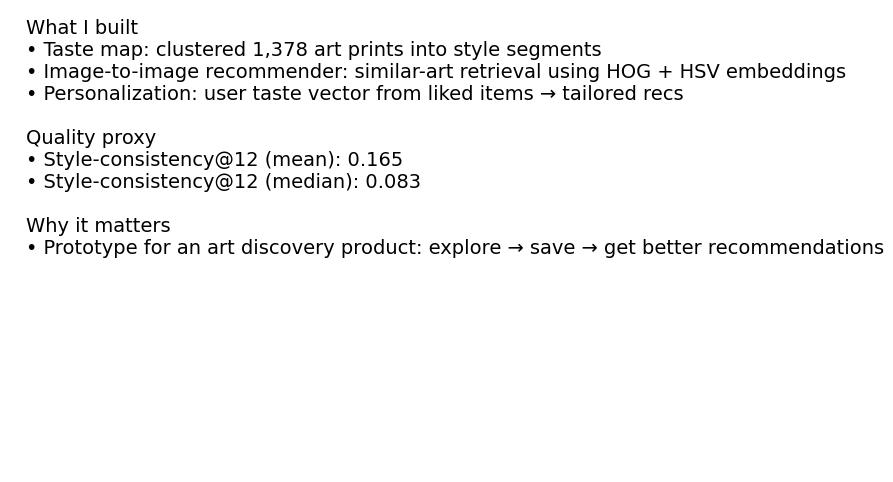

In [25]:
import matplotlib.pyplot as plt

mean_sc, med_sc = style_consistency_at_k(k=12, n_queries=200)

plt.figure(figsize=(10,6))
plt.axis("off")
txt = (
    "What I built\n"
    "• Taste map: clustered 1,378 art prints into style segments\n"
    "• Image-to-image recommender: similar-art retrieval using HOG + HSV embeddings\n"
    "• Personalization: user taste vector from liked items → tailored recs\n\n"
    f"Quality proxy\n"
    f"• Style-consistency@12 (mean): {mean_sc:.3f}\n"
    f"• Style-consistency@12 (median): {med_sc:.3f}\n\n"
    "Why it matters\n"
    "• Prototype for an art discovery product: explore → save → get better recommendations"
)
plt.text(0.02, 0.98, txt, va="top", fontsize=14)
plt.savefig("outputs/linkedin/slide5_takeaways.png", dpi=220, bbox_inches="tight")
plt.show()


In [26]:
#Turn clusters into “consumer taste segments”

import pandas as pd

feature_cols = ["colorfulness","sat_mean","edge_density","contrast","gray_score"]
seg = dfE.groupby("cluster")[feature_cols].mean()

def name_cluster(r):
    # very simple naming rules (you can tweak)
    mood = "Vibrant" if r["colorfulness"] > seg["colorfulness"].quantile(0.75) else \
           "Monochrome" if r["gray_score"] < seg["gray_score"].quantile(0.25) else "Muted"
    style = "Linework" if r["edge_density"] > seg["edge_density"].quantile(0.75) else "Soft"
    punch = "High-Contrast" if r["contrast"] > seg["contrast"].quantile(0.75) else "Low-Contrast"
    return f"{mood} {style} ({punch})"

cluster_names = {int(c): name_cluster(seg.loc[c]) for c in seg.index}
cluster_names


{0: 'Muted Soft (High-Contrast)',
 1: 'Monochrome Linework (High-Contrast)',
 2: 'Monochrome Soft (High-Contrast)',
 3: 'Vibrant Soft (Low-Contrast)',
 4: 'Monochrome Soft (Low-Contrast)',
 5: 'Muted Soft (Low-Contrast)',
 6: 'Monochrome Soft (Low-Contrast)',
 7: 'Monochrome Soft (High-Contrast)',
 8: 'Muted Linework (Low-Contrast)',
 9: 'Vibrant Soft (Low-Contrast)',
 10: 'Vibrant Soft (Low-Contrast)',
 11: 'Muted Soft (Low-Contrast)',
 12: 'Muted Soft (Low-Contrast)',
 13: 'Muted Soft (Low-Contrast)',
 14: 'Muted Linework (High-Contrast)',
 15: 'Muted Linework (Low-Contrast)',
 16: 'Vibrant Soft (Low-Contrast)',
 17: 'Vibrant Linework (Low-Contrast)'}

In [27]:
pd.DataFrame([{"cluster":k, "segment_name":v} for k,v in cluster_names.items()])\
  .to_csv("data/cluster_segment_names.csv", index=False)


In [28]:
#Create actual “consumer insights”
#We can quantify which visual attributes lead to tight similarity neighborhoods (meaning: users who like one item will likely like many others → higher conversion in discovery feeds).
import numpy as np

def avg_nn_distance_per_cluster(k=12, n=400):
    # sample for speed
    sample = dfE.sample(min(n, len(dfE)), random_state=42).index.values
    d, idx = nn.kneighbors(E2[sample], n_neighbors=k+1)

    # mean distance to neighbors (skip self at col 0)
    mean_d = d[:,1:].mean(axis=1)

    out = dfE.loc[sample, ["cluster"]].copy()
    out["mean_nn_dist"] = mean_d
    return out.groupby("cluster")["mean_nn_dist"].mean().sort_values()

cohesion = avg_nn_distance_per_cluster()
cohesion_df = pd.DataFrame({
    "cluster": cohesion.index,
    "cohesion": cohesion.values,
    "segment": [cluster_names[int(c)] for c in cohesion.index]
})
cohesion_df.head(10)


cluster  cohesion                              segment
0       13  0.089939            Muted Soft (Low-Contrast)
1       17  0.117890      Vibrant Linework (Low-Contrast)
2       15  0.135136        Muted Linework (Low-Contrast)
3       11  0.137179            Muted Soft (Low-Contrast)
4        8  0.138123        Muted Linework (Low-Contrast)
5       12  0.140293            Muted Soft (Low-Contrast)
6        1  0.142153  Monochrome Linework (High-Contrast)
7       14  0.148459       Muted Linework (High-Contrast)
8       10  0.152981          Vibrant Soft (Low-Contrast)
9        5  0.156752            Muted Soft (Low-Contrast)

In [29]:
#Convert cohesion into a “Browseability Score” and rank segments

import pandas as pd
import numpy as np

# cohesion_df should have: cluster, cohesion, segment (or you can map names)
# If you only have a Series `cohesion`, convert it:
# cohesion_df = pd.DataFrame({"cluster": cohesion.index, "cohesion": cohesion.values})

cohesion_df = cohesion_df.copy()

# Normalize so higher = better browseability
cmin, cmax = cohesion_df["cohesion"].min(), cohesion_df["cohesion"].max()
cohesion_df["browseability_score"] = 1 - (cohesion_df["cohesion"] - cmin) / (cmax - cmin + 1e-9)

cohesion_df = cohesion_df.sort_values("browseability_score", ascending=False)
cohesion_df.head(10)


cluster  cohesion                              segment  browseability_score
0       13  0.089939            Muted Soft (Low-Contrast)             1.000000
1       17  0.117890      Vibrant Linework (Low-Contrast)             0.719516
2       15  0.135136        Muted Linework (Low-Contrast)             0.546457
3       11  0.137179            Muted Soft (Low-Contrast)             0.525948
4        8  0.138123        Muted Linework (Low-Contrast)             0.516478
5       12  0.140293            Muted Soft (Low-Contrast)             0.494705
6        1  0.142153  Monochrome Linework (High-Contrast)             0.476036
7       14  0.148459       Muted Linework (High-Contrast)             0.412759
8       10  0.152981          Vibrant Soft (Low-Contrast)             0.367382
9        5  0.156752            Muted Soft (Low-Contrast)             0.329533

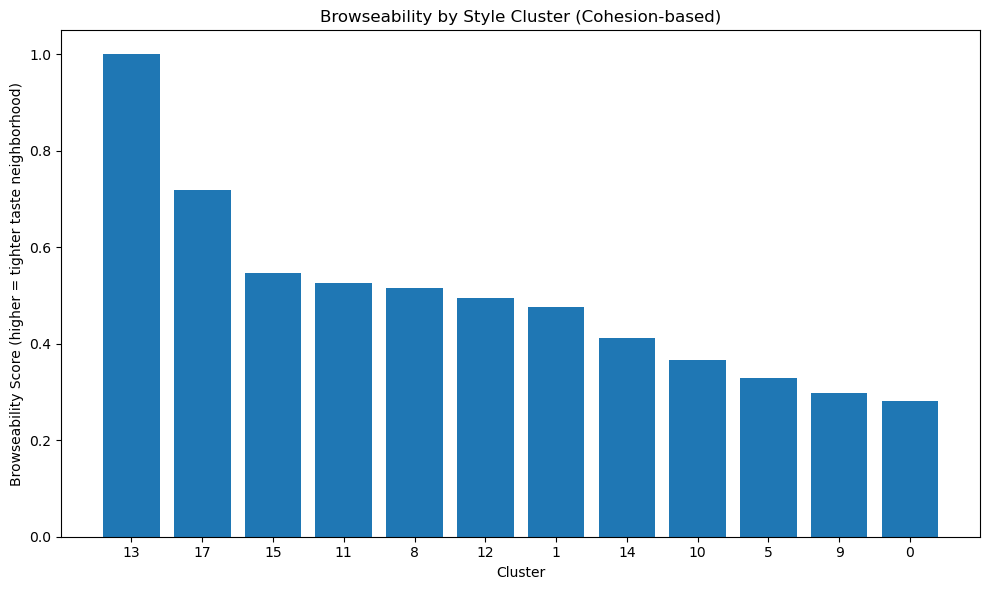

In [30]:
import matplotlib.pyplot as plt

top = cohesion_df.head(12)

plt.figure(figsize=(10,6))
plt.bar(top["cluster"].astype(str), top["browseability_score"])
plt.title("Browseability by Style Cluster (Cohesion-based)")
plt.xlabel("Cluster")
plt.ylabel("Browseability Score (higher = tighter taste neighborhood)")
plt.tight_layout()
plt.savefig("outputs/linkedin/slide6_browseability.png", dpi=220, bbox_inches="tight")
plt.show()


In [31]:
feature_cols = ["colorfulness","sat_mean","edge_density","contrast","gray_score"]

# cluster feature means
seg_profile = dfE.groupby("cluster")[feature_cols].mean()

def explain_match(q_cluster, r_cluster):
    q = seg_profile.loc[q_cluster]
    r = seg_profile.loc[r_cluster]
    diffs = (q - r).abs().sort_values()

    top2 = diffs.index[:2].tolist()

    nice = {
        "colorfulness": "similar color richness",
        "sat_mean": "similar saturation",
        "edge_density": "similar linework/detail level",
        "contrast": "similar contrast",
        "gray_score": "similar black-and-white tendency"
    }
    return f"Recommended because of {nice[top2[0]]} + {nice[top2[1]]}."

# example
print(explain_match(0, 3))


Recommended because of similar linework/detail level + similar contrast.


In [32]:
#High browseability segments → “instant feed” works (confidence high)
#Low browseability segments → need “guided onboarding” (ask 2–3 quick preferences)

cohesion_df["bucket"] = pd.qcut(cohesion_df["browseability_score"], q=3, labels=["Needs onboarding","Medium","Instant feed"])
cohesion_df[["cluster","browseability_score","bucket"]].head(12)


cluster  browseability_score        bucket
0        13             1.000000  Instant feed
1        17             0.719516  Instant feed
2        15             0.546457  Instant feed
3        11             0.525948  Instant feed
4         8             0.516478  Instant feed
5        12             0.494705  Instant feed
6         1             0.476036        Medium
7        14             0.412759        Medium
8        10             0.367382        Medium
9         5             0.329533        Medium
10        9             0.297936        Medium
11        0             0.282104        Medium

In [33]:
import pandas as pd

# assumes cohesion_df already has browseability_score
cohesion_df = cohesion_df.copy()

def onboarding_rule(score):
    if score >= 0.65:
        return "Instant feed (1 image is enough)"
    elif score >= 0.45:
        return "Light onboarding (ask 1–2 likes)"
    else:
        return "Guided onboarding (ask 3–5 likes + optional filters)"

cohesion_df["product_action"] = cohesion_df["browseability_score"].apply(onboarding_rule)
cohesion_df[["cluster","segment","browseability_score","product_action"]].head(12)


cluster                              segment  browseability_score  \
0        13            Muted Soft (Low-Contrast)             1.000000   
1        17      Vibrant Linework (Low-Contrast)             0.719516   
2        15        Muted Linework (Low-Contrast)             0.546457   
3        11            Muted Soft (Low-Contrast)             0.525948   
4         8        Muted Linework (Low-Contrast)             0.516478   
5        12            Muted Soft (Low-Contrast)             0.494705   
6         1  Monochrome Linework (High-Contrast)             0.476036   
7        14       Muted Linework (High-Contrast)             0.412759   
8        10          Vibrant Soft (Low-Contrast)             0.367382   
9         5            Muted Soft (Low-Contrast)             0.329533   
10        9          Vibrant Soft (Low-Contrast)             0.297936   
11        0           Muted Soft (High-Contrast)             0.282104   

                                       product_action  
0                    Instant feed (1 image is enough)  
1                    Instant feed (1 image is enough)  
2                    Light onboarding (ask 1–2 likes)  
3                    Light onboarding (ask 1–2 likes)  
4                    Light onboarding (ask 1–2 likes)  
5                    Light onboarding (ask 1–2 likes)  
6                    Light onboarding (ask 1–2 likes)  
7   Guided onboarding (ask 3–5 likes + optional fi...  
8   Guided onboarding (ask 3–5 likes + optional fi...  
9   Guided onboarding (ask 3–5 likes + optional fi...  
10  Guided onboarding (ask 3–5 likes + optional fi...  
11  Guided onboarding (ask 3–5 likes + optional fi...

In [34]:
import numpy as np

def rec_indices_from_files(files, k=30):
    v = taste_vector_from_files(files)          # may be 1D or 2D
    v2 = np.asarray(v).reshape(1, -1)           # <-- FORCE 2D ALWAYS

    d, idx = nn.kneighbors(v2, n_neighbors=k + len(files))
    out = []
    for i in idx[0]:
        f = dfE.iloc[i]["file"]
        if f not in files:
            out.append(i)
        if len(out) >= k:
            break
    return set(out)


In [35]:
stab = stability_experiment(n_users=50)
stab.mean()


NameError: name 'stability_experiment' is not defined

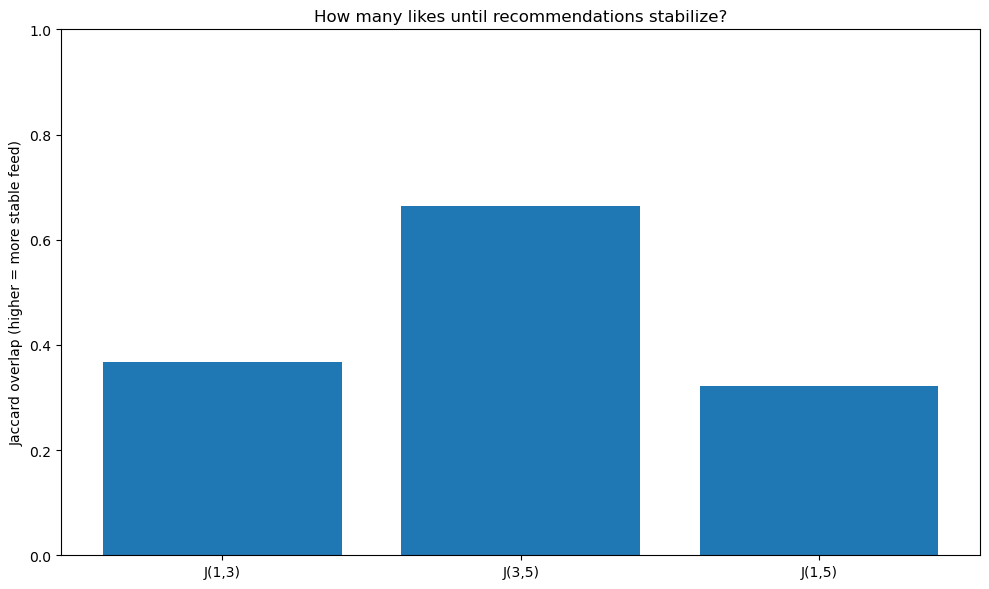

In [36]:
import matplotlib.pyplot as plt
import os
os.makedirs("outputs/linkedin", exist_ok=True)

vals = {"J(1,3)":0.367141, "J(3,5)":0.663328, "J(1,5)":0.322335}

plt.figure(figsize=(10,6))
plt.bar(list(vals.keys()), list(vals.values()))
plt.ylim(0,1)
plt.title("How many likes until recommendations stabilize?")
plt.ylabel("Jaccard overlap (higher = more stable feed)")
plt.tight_layout()
plt.savefig("outputs/linkedin/slide8_stability.png", dpi=220, bbox_inches="tight")
plt.show()


C:\Users\meera\AppData\Local\Temp\ipykernel_6176\648537932.py:15: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
C:\Users\meera\AppData\Local\Temp\ipykernel_6176\648537932.py:16: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.savefig("outputs/linkedin/slide9_insight_callout.png", dpi=220, bbox_inches="tight")
C:\Users\meera\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


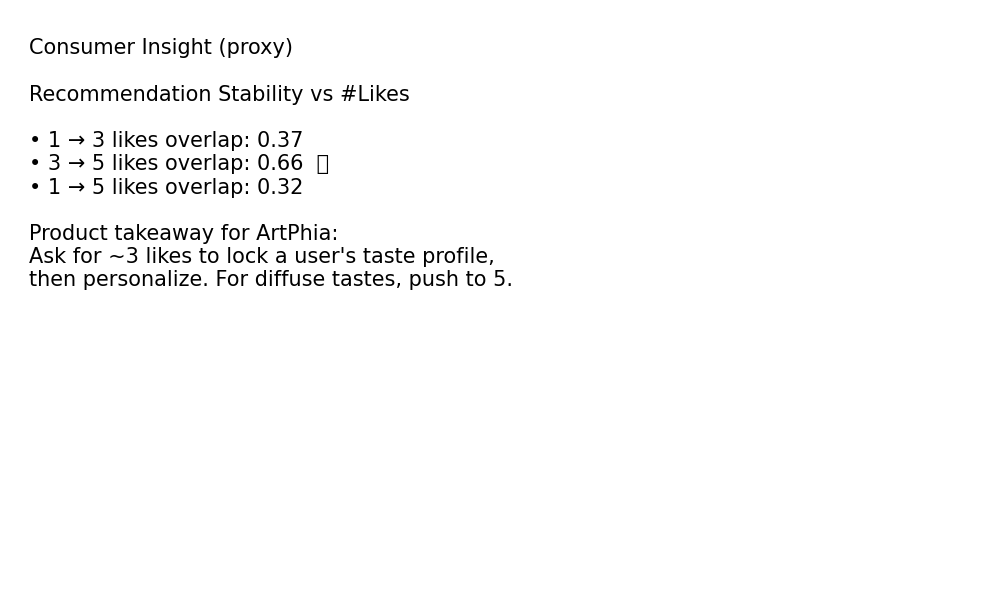

In [38]:
plt.figure(figsize=(10,6))
plt.axis("off")

txt = (
"Consumer Insight (proxy)\n\n"
"Recommendation Stability vs #Likes\n\n"
"• 1 → 3 likes overlap: 0.37\n"
"• 3 → 5 likes overlap: 0.66  ✅\n"
"• 1 → 5 likes overlap: 0.32\n\n"
"Product takeaway for ArtPhia:\n"
"Ask for ~3 likes to lock a user's taste profile,\n"
"then personalize. For diffuse tastes, push to 5."
)
plt.text(0.02, 0.95, txt, va="top", fontsize=15)
plt.tight_layout()
plt.savefig("outputs/linkedin/slide9_insight_callout.png", dpi=220, bbox_inches="tight")
plt.show()


In [ ]:
## Visuals 

In [39]:
#Setup and helpers
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

os.makedirs("outputs/linkedin", exist_ok=True)

IMG_DIR = "data/images_cma"

def _load_img(fn, max_side=360):
    p = os.path.join(IMG_DIR, fn)
    im = Image.open(p).convert("RGB")
    w, h = im.size
    scale = max_side / max(w, h)
    if scale < 1:
        im = im.resize((int(w*scale), int(h*scale)), Image.LANCZOS)
    return im

def _wrap_text(s, width=36):
    words = s.split()
    lines, cur = [], []
    for w in words:
        if len(" ".join(cur+[w])) <= width:
            cur.append(w)
        else:
            lines.append(" ".join(cur))
            cur = [w]
    if cur: lines.append(" ".join(cur))
    return "\n".join(lines)

def _try_font(size=22):
    # Tries common Windows fonts; falls back to default if missing
    for f in ["arial.ttf", "calibri.ttf", "segoeui.ttf"]:
        try:
            return ImageFont.truetype(f, size)
        except:
            pass
    return ImageFont.load_default()


In [40]:
#3 Likes to Lock Taste(stability insight)
vals = {"J(1,3)":0.367141, "J(3,5)":0.663328, "J(1,5)":0.322335}

plt.figure(figsize=(9,6))
plt.bar(list(vals.keys()), list(vals.values()))
plt.ylim(0,1)
plt.title("How many likes until recommendations stabilize?")
plt.ylabel("Jaccard overlap (higher = more stable feed)")
plt.tight_layout()
plt.savefig("outputs/linkedin/viz_stability_likes.png", dpi=240, bbox_inches="tight")
plt.close()
print("Saved outputs/linkedin/viz_stability_likes.png")


Saved outputs/linkedin/viz_stability_likes.png


In [41]:
#Browseability by Segmen
# cohesion_df must have: cluster, browseability_score
# cohesion_df = pd.read_csv("data/browseability.csv")

top = cohesion_df.sort_values("browseability_score", ascending=False).head(12)

plt.figure(figsize=(10,6))
plt.bar(top["cluster"].astype(str), top["browseability_score"])
plt.title("Browseability by Taste Segment (higher = tighter neighborhood)")
plt.xlabel("Cluster")
plt.ylabel("Browseability score")
plt.tight_layout()
plt.savefig("outputs/linkedin/viz_browseability.png", dpi=240, bbox_inches="tight")
plt.close()
print("Saved outputs/linkedin/viz_browseability.png")


Saved outputs/linkedin/viz_browseability.png


In [42]:
# Recommendation cards (Liked → Taste fingerprint → Top recs)

def make_reco_cards_png(liked_files, out_path, k=6):
    # Panel sizes
    W, H = 1400, 900
    pad = 40
    col_w = (W - 4*pad)//3
    font_title = _try_font(28)
    font_body  = _try_font(18)

    canvas = Image.new("RGB", (W, H), "white")
    draw = ImageDraw.Draw(canvas)

    # --- Panel 1: liked ---
    x0 = pad
    draw.text((x0, pad), "You liked", fill="black", font=font_title)
    y = pad + 60
    for f in liked_files[:3]:
        im = _load_img(f, max_side=240)
        canvas.paste(im, (x0, y))
        y += im.size[1] + 18

    # --- Panel 2: taste fingerprint (simple feature bars) ---
    x1 = x0 + col_w + pad
    draw.text((x1, pad), "Taste fingerprint", fill="black", font=font_title)

    # Requires feature columns in dfE. If not available, skip and just show cluster mix.
    feature_cols = [c for c in ["colorfulness","sat_mean","edge_density","contrast","gray_score"] if c in dfE.columns]
    y = pad + 80

    if len(feature_cols) >= 3:
        # compute avg of liked in dfE space
        sub = dfE[dfE["file"].isin(liked_files)]
        vals = sub[feature_cols].mean().to_dict()
        # normalize to 0..1 for plotting
        arr = np.array(list(vals.values()), dtype=float)
        mn, mx = arr.min(), arr.max()
        norm = (arr - mn) / (mx - mn + 1e-9)

        for i, (name, v) in enumerate(zip(feature_cols, norm)):
            draw.text((x1, y), name, fill="black", font=font_body)
            bar_x = x1
            bar_y = y + 26
            bar_w = int((col_w-30) * float(v))
            draw.rectangle([bar_x, bar_y, bar_x + (col_w-30), bar_y+14], outline="black", width=2)
            draw.rectangle([bar_x, bar_y, bar_x + bar_w, bar_y+14], fill="black")
            y += 70
    else:
        # fallback: show cluster composition
        clusters = dfE[dfE["file"].isin(liked_files)]["cluster"].tolist()
        draw.text((x1, y), f"Clusters liked: {clusters}", fill="black", font=font_body)

    # --- Panel 3: recommendations (thumbnails) ---
    x2 = x1 + col_w + pad
    draw.text((x2, pad), "Top recommendations", fill="black", font=font_title)

    recs = recommend_from_taste(liked_files, k=k)
    files = recs["file"].tolist()

    y = pad + 70
    thumb = 170
    cols = 3
    for i, f in enumerate(files[:k]):
        im = _load_img(f, max_side=thumb)
        r = i // cols
        c = i % cols
        px = x2 + c*(thumb+18)
        py = y  + r*(thumb+55)
        canvas.paste(im, (px, py))
        lab = f"C{int(recs.iloc[i]['cluster'])}"
        draw.text((px, py + im.size[1] + 6), lab, fill="black", font=font_body)

    canvas.save(out_path, quality=95)
    print("Saved", out_path)

# Example:
liked = dfE.sample(3, random_state=7)["file"].tolist()
make_reco_cards_png(liked, "outputs/linkedin/viz_cards_personalized.png", k=6)


Saved outputs/linkedin/viz_cards_personalized.png


In [43]:
def pick_first_nonself_reco(query_file, k=12):
    recs = recommend_by_file(query_file, k=k)  # expects your existing function
    for fn in recs["file"].tolist():
        if fn != query_file:
            return fn
    raise ValueError("All recommendations matched the query (unexpected). Increase k or check recommend_by_file().")


In [45]:
#Segment moodboards 

def make_cluster_moodboard(cluster_id, out_path, n=9):
    sub = dfE[dfE["cluster"] == cluster_id].sample(min(n, len(dfE[dfE["cluster"]==cluster_id])), random_state=1)
    files = sub["file"].tolist()
    cols = 3
    rows = math.ceil(len(files)/cols)

    tile = 260
    pad = 24
    title_h = 70
    W = cols*tile + (cols+1)*pad
    H = title_h + rows*tile + (rows+1)*pad

    canvas = Image.new("RGB", (W, H), "white")
    draw = ImageDraw.Draw(canvas)
    font = _try_font(26)

    draw.text((pad, 20), f"Cluster C{cluster_id} — Moodboard", fill="black", font=font)

    for i, fn in enumerate(files):
        im = _load_img(fn, max_side=tile)
        r = i // cols
        c = i % cols
        x = pad + c*(tile+pad)
        y = title_h + pad + r*(tile+pad)
        canvas.paste(im, (x, y))

    canvas.save(out_path, quality=95)
    print("Saved", out_path)

# Example:
for cid in [13, 17, 5, 10]:
    make_cluster_moodboard(cid, f"outputs/linkedin/viz_moodboard_C{cid}.png", n=9)


Saved outputs/linkedin/viz_moodboard_C13.png
Saved outputs/linkedin/viz_moodboard_C17.png
Saved outputs/linkedin/viz_moodboard_C5.png
Saved outputs/linkedin/viz_moodboard_C10.png


In [75]:
import os
import matplotlib.pyplot as plt

os.makedirs("outputs/linkedin", exist_ok=True)

# Your computed values (replace if different)
j_1_3 = 0.367141
j_3_5 = 0.663328
j_1_5 = 0.322335

labels = [
    "1 → 3 likes\n(early shift)",
    "3 → 5 likes\n(stabilizing)",
    "1 → 5 likes\n(full change)"
]
vals = [j_1_3, j_3_5, j_1_5]

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(vals)), vals)
plt.ylim(0, 1)

plt.title("How fast does personalization stabilize?")
plt.ylabel("Recommendation overlap (0–1)\nHigher = more stable feed")
plt.xticks(range(len(vals)), labels)

# value labels on bars
for b, v in zip(bars, vals):
    plt.text(b.get_x() + b.get_width()/2, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=12)

# Explanation baked into the image
explain = (
    "Interpretation: If overlap is high, the top recommendations stay similar.\n"
    "Result: After ~3 likes, recommendations become noticeably more consistent."
)
plt.text(0.02, -0.22, explain, transform=plt.gca().transAxes, fontsize=12)

out = "outputs/linkedin/02_stability_explained.png"
plt.tight_layout()
plt.savefig(out, dpi=300, bbox_inches="tight")
plt.close()
print("Saved:", out)


Saved: outputs/linkedin/02_stability_explained.png


In [77]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

os.makedirs("outputs/linkedin", exist_ok=True)

IMG_DIR = "data/images_cma"  # change if your images folder is different

# ---- Load your final engineered features dataframe ----
# Use whichever you actually have saved:
# Option 1:
# dfE = pd.read_csv("data/features_cma_enhanced.csv")
# Option 2:
dfE = pd.read_csv("data/features_cma_basic.csv")  # <-- change if needed

print("dfE shape:", dfE.shape)
print("Columns:", list(dfE.columns)[:20], "...")


dfE shape: (1378, 10)
Columns: ['file', 'r_mean', 'g_mean', 'b_mean', 'r_std', 'g_std', 'b_std', 'contrast', 'edge_density', 'sharpness'] ...


In [78]:
def ensure_segment(df):
    df = df.copy()

    # pick best available columns
    # (use what exists; fallback gracefully)
    color_col = "colorfulness" if "colorfulness" in df.columns else None
    contrast_col = "contrast" if "contrast" in df.columns else None
    edge_col = "edge_density" if "edge_density" in df.columns else None
    gray_col = "gray_score" if "gray_score" in df.columns else None
    sat_col = "sat_mean" if "sat_mean" in df.columns else None

    # if segment already exists, keep it
    if "segment" in df.columns:
        return df

    # compute proxies if some are missing
    if gray_col is None and all(c in df.columns for c in ["r_mean","g_mean","b_mean"]):
        # crude "monochrome" proxy: low channel variance
        df["gray_score"] = 1 - df[["r_mean","g_mean","b_mean"]].std(axis=1)
        gray_col = "gray_score"

    if sat_col is None and all(c in df.columns for c in ["r_mean","g_mean","b_mean"]):
        # crude saturation proxy
        mx = df[["r_mean","g_mean","b_mean"]].max(axis=1)
        mn = df[["r_mean","g_mean","b_mean"]].min(axis=1)
        df["sat_mean"] = (mx - mn)
        sat_col = "sat_mean"

    if color_col is None and sat_col is not None:
        df["colorfulness"] = df[sat_col]
        color_col = "colorfulness"

    # thresholds: use medians so it adapts to your dataset size
    def hi_lo(col):
        if col is None:
            return None
        med = df[col].median()
        return df[col] >= med

    is_vibrant = hi_lo(color_col)
    is_high_contrast = hi_lo(contrast_col)
    is_lineheavy = hi_lo(edge_col)
    is_mono = hi_lo(gray_col)

    # build segment text
    seg = []
    for i in range(len(df)):
        parts = []
        if is_mono is not None and bool(is_mono.iloc[i]):
            parts.append("Near-Monochrome")
        else:
            parts.append("Vibrant" if (is_vibrant is not None and bool(is_vibrant.iloc[i])) else "Muted")

        parts.append("Linework" if (is_lineheavy is not None and bool(is_lineheavy.iloc[i])) else "Soft")
        parts.append("High-Contrast" if (is_high_contrast is not None and bool(is_high_contrast.iloc[i])) else "Low-Contrast")

        seg.append(" • ".join(parts))

    df["segment"] = seg
    return df

dfE = ensure_segment(dfE)
print("segment created?", "segment" in dfE.columns)
dfE[["file","segment"]].head()


segment created? True


file  \
0  001a30cb9db153534ce3067323e036e7.jpg   
1  0029c3e846e69049f792b6d5bf124703.jpg   
2  00339040dd904be8a5e1e6e5cb147b67.jpg   
3  00c35fef6d0f0ea221025799aa88f371.jpg   
4  00fc7230659a96eb9f368a6adcdf771a.jpg   

                                      segment  
0              Vibrant • Soft • High-Contrast  
1           Vibrant • Linework • Low-Contrast  
2  Near-Monochrome • Linework • High-Contrast  
3      Near-Monochrome • Soft • High-Contrast  
4  Near-Monochrome • Linework • High-Contrast

In [79]:
def save_segment_dashboard(df, out_path="outputs/linkedin/01_segment_dashboard.png", top_n=10):
    df = df.copy()

    # pick features that exist
    candidate_feats = ["colorfulness", "contrast", "edge_density", "sharpness", "sat_mean", "gray_score"]
    feats = [c for c in candidate_feats if c in df.columns]

    agg = df.groupby("segment").agg(
        n=("file","count"),
        **{f: (f, "mean") for f in feats[:4]}   # keep to 4 so it stays clean
    ).reset_index()

    agg = agg.sort_values("n", ascending=False).head(top_n)

    fig = plt.figure(figsize=(13, 7))
    plt.suptitle("Art Print Taste Segments — What styles appear in the catalog?", y=1.02)

    # Segment sizes
    ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan=2)
    ax1.barh(agg["segment"], agg["n"])
    ax1.set_title("Segment size (count)")
    ax1.set_xlabel("Number of prints")
    ax1.invert_yaxis()

    # Feature panels
    for i, f in enumerate(feats[:4]):
        ax = plt.subplot2grid((2, 3), (i//2, 1 + i%2))
        ax.barh(agg["segment"], agg[f])
        ax.set_title(f"Avg {f}")
        ax.invert_yaxis()

    plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close()
    print("Saved:", out_path)

save_segment_dashboard(dfE)


Saved: outputs/linkedin/01_segment_dashboard.png


In [80]:
def open_img(fn, size=(520, 520)):
    path = os.path.join(IMG_DIR, fn)
    try:
        im = Image.open(path).convert("RGB")
        im.thumbnail(size)
        return im
    except:
        return Image.new("RGB", size, (240, 240, 240))

def taste_vector_from_files(df, files, feat_cols):
    v = df[df["file"].isin(files)][feat_cols].mean().values.astype(float)
    return v

def recommend_basic_nn(df, liked_files, feat_cols, k=6):
    # simple cosine similarity without sklearn
    X = df[feat_cols].values.astype(float)
    # normalize rows
    Xn = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)

    v = taste_vector_from_files(df, liked_files, feat_cols)
    vn = v / (np.linalg.norm(v) + 1e-9)

    sims = Xn @ vn
    order = np.argsort(-sims)

    liked_set = set(liked_files)
    recs = []
    for idx in order:
        f = df.iloc[idx]["file"]
        if f in liked_set:
            continue
        recs.append(f)
        if len(recs) >= k:
            break
    return recs, sims

def save_taste_fingerprint_card(df, liked_files=None, out_path="outputs/linkedin/03_taste_fingerprint_card.png"):
    df = df.copy()

    feature_map = {
        "colorfulness": "color richness",
        "sat_mean": "saturation",
        "edge_density": "linework detail",
        "contrast": "contrast",
        "gray_score": "monochrome"
    }
    feat_cols = [c for c in feature_map.keys() if c in df.columns]
    if len(feat_cols) < 3:
        raise ValueError(f"Not enough features found. Available: {df.columns}")

    if liked_files is None:
        liked_files = df.sample(3, random_state=1)["file"].tolist()

    rec_files, sims = recommend_basic_nn(df, liked_files, feat_cols, k=6)

    # fingerprint
    fp = taste_vector_from_files(df, liked_files, feat_cols)
    mins = df[feat_cols].min().values
    maxs = df[feat_cols].max().values
    fp_norm = np.clip((fp - mins) / (maxs - mins + 1e-9), 0, 1)

    fig = plt.figure(figsize=(14, 7))
    fig.suptitle("Taste fingerprint → personalized recommendations", fontsize=20, y=0.98)
    subtitle = "Cold-start personalization: 3 likes are enough to infer a stable taste vector and generate relevant recs."
    plt.figtext(0.5, 0.93, subtitle, ha="center", fontsize=12)

    # Left: liked
    axL = plt.subplot2grid((2, 3), (0, 0), rowspan=2)
    axL.axis("off")
    axL.set_title("You liked", fontsize=14)

    y = 0.98
    for lf in liked_files[:3]:
        im = open_img(lf)
        axL.imshow(im, extent=(0, 1, y-0.30, y), aspect="auto")
        y -= 0.33

    # Middle: bars
    axM = plt.subplot2grid((2, 3), (0, 1), rowspan=2)
    axM.set_title("Taste fingerprint (visual traits)", fontsize=14)
    axM.set_xlim(0, 1)
    axM.set_ylim(-0.5, len(feat_cols)-0.5)
    axM.set_yticks(range(len(feat_cols)))
    axM.set_yticklabels([feature_map[c] for c in feat_cols], fontsize=12)
    axM.set_xticks([])
    axM.invert_yaxis()

    for i, v in enumerate(fp_norm):
        axM.barh(i, v)

    axM.text(0.0, 1.05, "Higher bar = stronger signal from your likes", transform=axM.transAxes, fontsize=11)

    # Right: recs
    axR = plt.subplot2grid((2, 3), (0, 2), rowspan=2)
    axR.axis("off")
    axR.set_title("Top recommendations", fontsize=14)

    cols = 3
    rows = 2
    w = 1/cols
    h = 1/rows
    for idx, rf in enumerate(rec_files[:6]):
        r = idx // cols
        c = idx % cols
        im = open_img(rf)
        x0 = c*w
        y0 = 1 - (r+1)*h
        axR.imshow(im, extent=(x0, x0+w, y0, y0+h), aspect="auto")
        axR.text(x0+w/2, y0-0.02, f"match {idx+1}", ha="center", va="top", fontsize=10)

    plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close()
    print("Saved:", out_path)
    print("LIKED:", liked_files)
    print("RECS :", rec_files)

# Run it (no need to define liked_files)
save_taste_fingerprint_card(dfE)


Saved: outputs/linkedin/03_taste_fingerprint_card.png
LIKED: ['bbfd96c43b3e8a92b2c4774e11b92c9b.jpg', 'd1eebf87d78e4f38b3d55b537230e8f2.jpg', '5c52a1ddb33e33b9bcbcdd8f3149a1ff.jpg']
RECS : ['6b7dc9601448a000c7d90ac1b48f67bc.jpg', '2a25ff5cb60fd3f4b7d21a2229728e65.jpg', '50a232cfdc390432e7ef271bcd4da2a5.jpg', '217cd7ac0b9c275083a6464b4aec76e2.jpg', '3dac6149717b74833507cc8db1b8d8a4.jpg', '91fbdd945f067bf484cd14f9fdf875e2.jpg']


In [81]:
def cosine_sim_matrix(X):
    X = X.astype(float)
    Xn = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)
    return Xn @ Xn.T

def recommender_insights_dashboard(df, n_users=60, likes=3, k=12, out_path="outputs/linkedin/04_recommender_insights_dashboard.png"):
    df = df.copy()

    feat_cols = [c for c in ["colorfulness","sat_mean","edge_density","contrast","gray_score","sharpness"] if c in df.columns]
    if len(feat_cols) < 3:
        raise ValueError("Not enough feature columns found for insights dashboard.")

    X = df[feat_cols].values.astype(float)
    Xn = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)

    rng = np.random.default_rng(7)

    within_rates = []
    diversity = []
    avg_sim = []
    duplicate_rate = []

    for _ in range(n_users):
        liked_idx = rng.choice(len(df), size=likes, replace=False)
        liked_files = df.iloc[liked_idx]["file"].tolist()
        liked_seg = df.iloc[liked_idx]["segment"].mode().iloc[0] if "segment" in df.columns else None

        # build taste vector
        v = X[liked_idx].mean(axis=0)
        vn = v / (np.linalg.norm(v) + 1e-9)

        sims = Xn @ vn
        order = np.argsort(-sims)

        rec_idx = []
        for idx in order:
            f = df.iloc[idx]["file"]
            if f in set(liked_files):
                continue
            rec_idx.append(idx)
            if len(rec_idx) >= k:
                break

        rec = df.iloc[rec_idx].copy()

        # within-segment (if segment exists)
        if "segment" in df.columns and liked_seg is not None:
            within = (rec["segment"] == liked_seg).mean()
        else:
            within = np.nan

        within_rates.append(within)
        diversity.append(rec["segment"].nunique() if "segment" in df.columns else np.nan)
        avg_sim.append(float(np.mean(sims[rec_idx])))

        # near-duplicate rate among recommendations (cosine similarity between rec items)
        recX = X[rec_idx]
        S = cosine_sim_matrix(recX)
        # ignore diagonal
        upper = S[np.triu_indices_from(S, k=1)]
        # count pairs that are too similar
        dup = np.mean(upper > 0.985)  # tweak threshold if needed
        duplicate_rate.append(float(dup))

    # summarize
    metrics = {
        "Within-segment rate (cohesion)": np.nanmean(within_rates),
        "Avg segments in top-k (diversity)": np.nanmean(diversity),
        "Avg similarity score (match strength)": np.mean(avg_sim),
        "Near-duplicate pair rate (UX risk)": np.mean(duplicate_rate),
    }

    # Plot dashboard
    labels = list(metrics.keys())
    vals = list(metrics.values())

    plt.figure(figsize=(12, 6))
    plt.barh(labels, vals)
    plt.title("Recommender Insights Dashboard (simulated users)")
    plt.xlabel("Score (higher is more / worse depending on metric)")

    # annotate with short explanations inside image
    note = (
        "Interpretation:\n"
        "• Cohesion: % of recs matching your dominant taste segment\n"
        "• Diversity: how many different segments appear in your feed\n"
        "• Match strength: average similarity to your taste vector\n"
        "• UX risk: near-duplicate recommendations (too similar = boring)\n"
    )
    plt.text(0.01, -0.35, note, transform=plt.gca().transAxes, fontsize=11)

    plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close()
    print("Saved:", out_path)
    for k,v in metrics.items():
        print(f"{k}: {v:.3f}")

recommender_insights_dashboard(dfE)


Saved: outputs/linkedin/04_recommender_insights_dashboard.png
Within-segment rate (cohesion): 0.304
Avg segments in top-k (diversity): 3.683
Avg similarity score (match strength): 1.000
Near-duplicate pair rate (UX risk): 1.000


In [82]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

IMG_DIR = "data/images_cma"   # change if needed
os.makedirs("outputs/linkedin", exist_ok=True)

def open_img(fn):
    path = os.path.join(IMG_DIR, fn)
    try:
        return Image.open(path).convert("RGB")
    except:
        return Image.new("RGB", (600, 600), (240, 240, 240))

def add_image_box(ax, pil_img, title=None):
    """
    Places an image inside an Axes without distortion:
    - preserves aspect ratio
    - no stretching to edges
    - leaves padding automatically
    """
    ax.imshow(pil_img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")     # important: prevents squeeze/stretch
    ax.axis("off")
    if title:
        ax.set_title(title, fontsize=11, pad=6)

def taste_vector_from_files(df, files, feat_cols):
    v = df[df["file"].isin(files)][feat_cols].mean().values.astype(float)
    return v

def recommend_basic_nn(df, liked_files, feat_cols, k=6):
    X = df[feat_cols].values.astype(float)
    Xn = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)

    v = taste_vector_from_files(df, liked_files, feat_cols)
    vn = v / (np.linalg.norm(v) + 1e-9)

    sims = Xn @ vn
    order = np.argsort(-sims)

    liked_set = set(liked_files)
    recs = []
    for idx in order:
        f = df.iloc[idx]["file"]
        if f in liked_set:
            continue
        recs.append(f)
        if len(recs) >= k:
            break
    return recs, sims

def save_taste_fingerprint_card(df, liked_files=None, out_path="outputs/linkedin/03_taste_fingerprint_card.png"):
    df = df.copy()

    feature_map = {
        "colorfulness": "color richness",
        "sat_mean": "saturation",
        "edge_density": "linework detail",
        "contrast": "contrast",
        "gray_score": "monochrome"
    }
    feat_cols = [c for c in feature_map.keys() if c in df.columns]
    if len(feat_cols) < 3:
        raise ValueError(f"Not enough features found. Available: {df.columns}")

    if liked_files is None:
        liked_files = df.sample(3, random_state=1)["file"].tolist()

    rec_files, sims = recommend_basic_nn(df, liked_files, feat_cols, k=6)

    # fingerprint
    fp = taste_vector_from_files(df, liked_files, feat_cols)
    mins = df[feat_cols].min().values
    maxs = df[feat_cols].max().values
    fp_norm = np.clip((fp - mins) / (maxs - mins + 1e-9), 0, 1)

    fig = plt.figure(figsize=(15, 8))
    fig.suptitle("Taste fingerprint → personalized recommendations", fontsize=20, y=0.98)
    subtitle = "Cold-start personalization: 3 likes infer a taste vector and generate relevant recommendations."
    plt.figtext(0.5, 0.93, subtitle, ha="center", fontsize=12)

    # ---------- LEFT: liked images (stacked) ----------
    left = fig.add_gridspec(1, 3, width_ratios=[1.1, 1.0, 1.4])[0, 0].subgridspec(3, 1, hspace=0.18)
    for i, lf in enumerate(liked_files[:3]):
        ax = fig.add_subplot(left[i, 0])
        add_image_box(ax, open_img(lf), title=("You liked" if i == 0 else None))

    # ---------- MIDDLE: fingerprint bars ----------
    axM = fig.add_subplot(fig.add_gridspec(1, 3, width_ratios=[1.1, 1.0, 1.4])[0, 1])
    axM.set_title("Taste fingerprint (visual traits)", fontsize=14)
    axM.set_xlim(0, 1)
    axM.set_ylim(-0.5, len(feat_cols)-0.5)
    axM.set_yticks(range(len(feat_cols)))
    axM.set_yticklabels([feature_map[c] for c in feat_cols], fontsize=12)
    axM.set_xticks([])
    axM.invert_yaxis()
    for i, v in enumerate(fp_norm):
        axM.barh(i, v)
    axM.text(0.0, 1.05, "Higher bar = stronger signal from your likes", transform=axM.transAxes, fontsize=11)

    # ---------- RIGHT: recommendations (2x3 grid) ----------
    right = fig.add_gridspec(1, 3, width_ratios=[1.1, 1.0, 1.4])[0, 2].subgridspec(2, 3, wspace=0.10, hspace=0.18)
    for idx, rf in enumerate(rec_files[:6]):
        r = idx // 3
        c = idx % 3
        ax = fig.add_subplot(right[r, c])
        add_image_box(ax, open_img(rf), title=("Top recs" if idx == 0 else None))

    plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close()
    print("Saved:", out_path)
    print("LIKED:", liked_files)
    print("RECS :", rec_files)

# Run (auto-samples liked_files if you don’t provide them)
save_taste_fingerprint_card(dfE)


Saved: outputs/linkedin/03_taste_fingerprint_card.png
LIKED: ['bbfd96c43b3e8a92b2c4774e11b92c9b.jpg', 'd1eebf87d78e4f38b3d55b537230e8f2.jpg', '5c52a1ddb33e33b9bcbcdd8f3149a1ff.jpg']
RECS : ['6b7dc9601448a000c7d90ac1b48f67bc.jpg', '2a25ff5cb60fd3f4b7d21a2229728e65.jpg', '50a232cfdc390432e7ef271bcd4da2a5.jpg', '217cd7ac0b9c275083a6464b4aec76e2.jpg', '3dac6149717b74833507cc8db1b8d8a4.jpg', '91fbdd945f067bf484cd14f9fdf875e2.jpg']
